# Phase 1 : ResNet18 Feature Extraction with TensorFlow


Loaded 606 images.


Extracting early features...
Extracting middle features...
Extracting high features...

--- EARLY FEATURES ---
Random Forest: Train Acc=1.0000, Test Acc=0.5902, Test Recall=0.5917, Test F1=0.5246
SVM (RBF): Train Acc=0.9442, Test Acc=0.5984, Test Recall=0.6012, Test F1=0.5220
SVM (Linear): Train Acc=1.0000, Test Acc=0.6311, Test Recall=0.6309, Test F1=0.6231
Logistic Regression: Train Acc=1.0000, Test Acc=0.6393, Test Recall=0.6390, Test F1=0.6307
Gradient Boosting: Train Acc=1.0000, Test Acc=0.6475, Test Recall=0.6476, Test F1=0.6319
KNN: Train Acc=0.5868, Test Acc=0.4344, Test Recall=0.4372, Test F1=0.4118
Decision Tree: Train Acc=0.9587, Test Acc=0.5410, Test Recall=0.5411, Test F1=0.5386


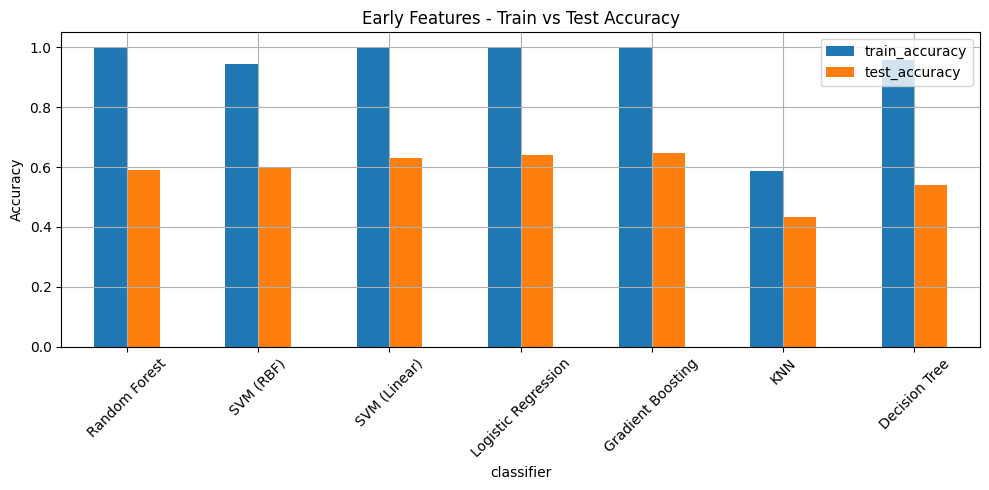


Showing 10 test examples for early features:


<Figure size 1500x600 with 0 Axes>

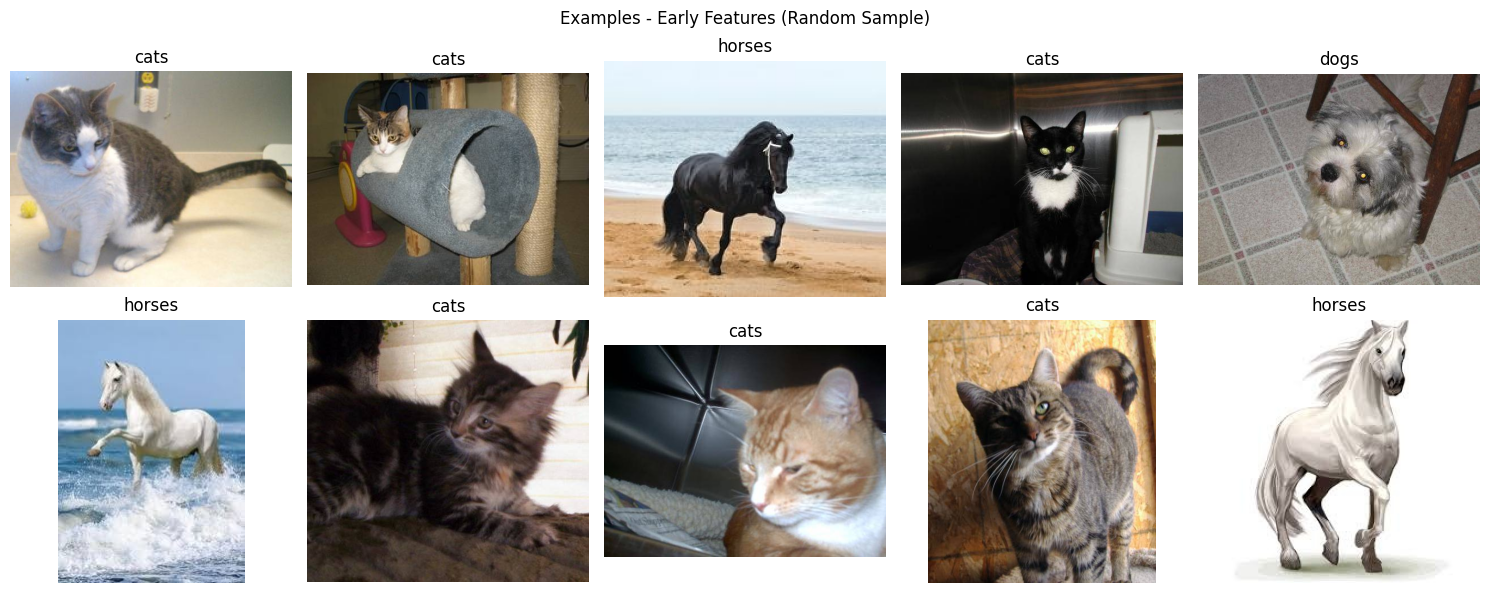


--- MIDDLE FEATURES ---
Random Forest: Train Acc=1.0000, Test Acc=0.6721, Test Recall=0.6734, Test F1=0.6419
SVM (RBF): Train Acc=0.9979, Test Acc=0.7049, Test Recall=0.7069, Test F1=0.6744
SVM (Linear): Train Acc=1.0000, Test Acc=0.8361, Test Recall=0.8360, Test F1=0.8348
Logistic Regression: Train Acc=1.0000, Test Acc=0.8197, Test Recall=0.8197, Test F1=0.8148
Gradient Boosting: Train Acc=1.0000, Test Acc=0.7131, Test Recall=0.7142, Test F1=0.7082
KNN: Train Acc=0.6839, Test Acc=0.5328, Test Recall=0.5358, Test F1=0.5116
Decision Tree: Train Acc=0.9711, Test Acc=0.6639, Test Recall=0.6652, Test F1=0.6458


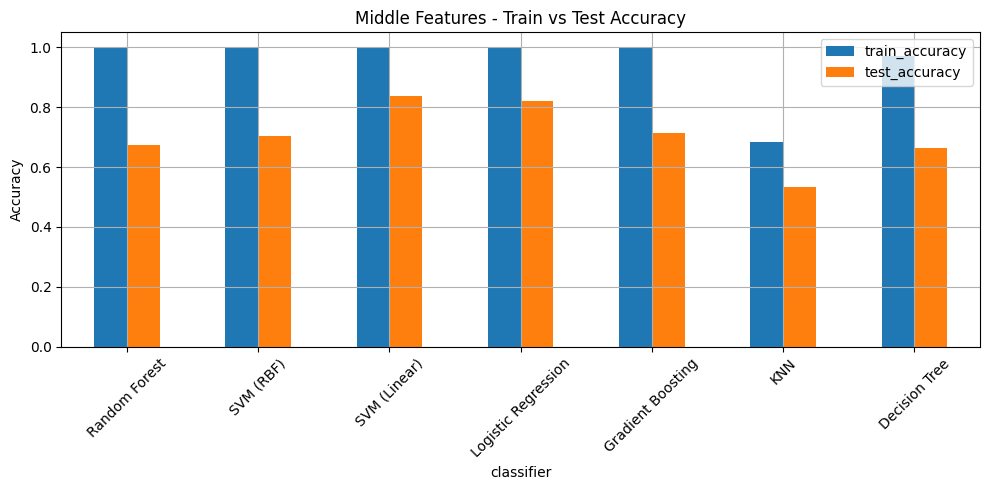


Showing 10 test examples for middle features:


<Figure size 1500x600 with 0 Axes>

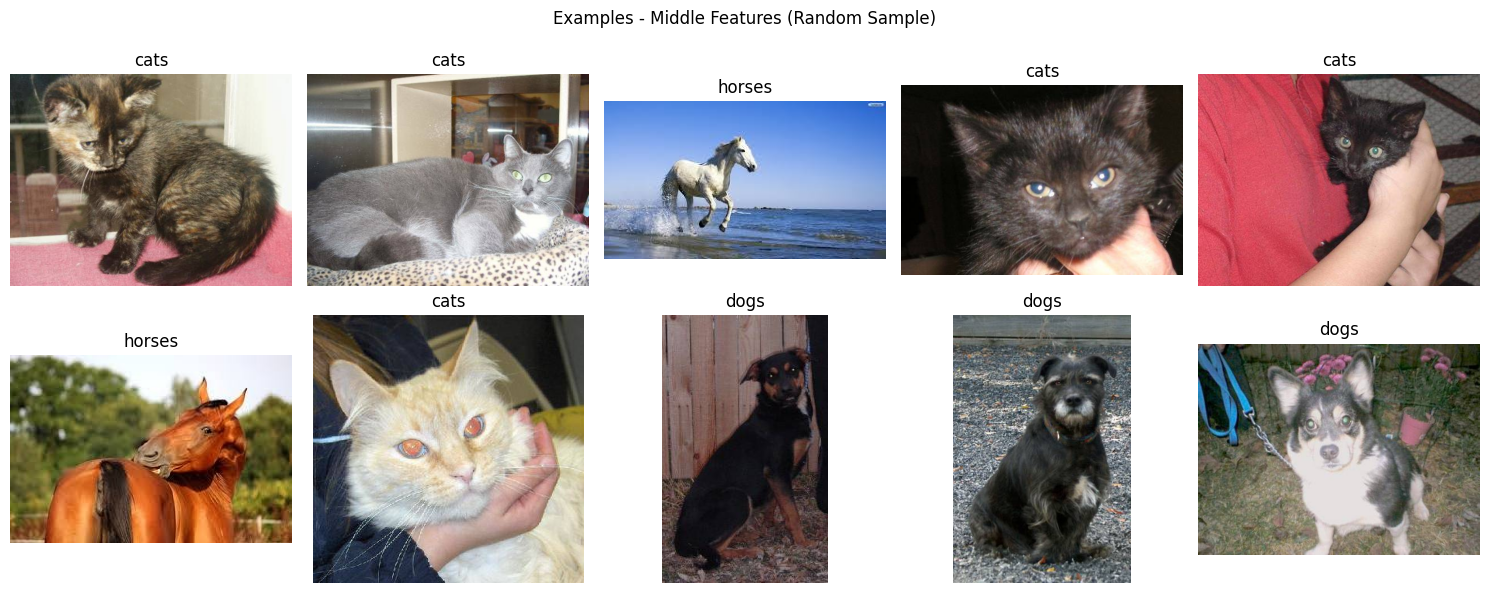


--- HIGH FEATURES ---
Random Forest: Train Acc=1.0000, Test Acc=0.9590, Test Recall=0.9591, Test F1=0.9589
SVM (RBF): Train Acc=1.0000, Test Acc=0.9590, Test Recall=0.9589, Test F1=0.9588
SVM (Linear): Train Acc=1.0000, Test Acc=0.9918, Test Recall=0.9919, Test F1=0.9918
Logistic Regression: Train Acc=1.0000, Test Acc=0.9836, Test Recall=0.9837, Test F1=0.9835
Gradient Boosting: Train Acc=1.0000, Test Acc=0.9344, Test Recall=0.9346, Test F1=0.9348
KNN: Train Acc=0.8740, Test Acc=0.7295, Test Recall=0.7317, Test F1=0.6627
Decision Tree: Train Acc=1.0000, Test Acc=0.8934, Test Recall=0.8937, Test F1=0.8927


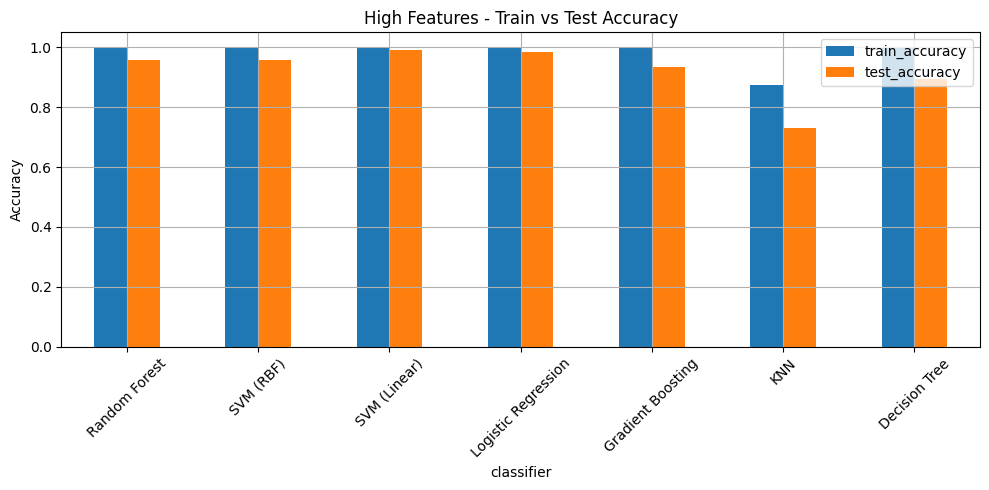


Showing 10 test examples for high features:


<Figure size 1500x600 with 0 Axes>

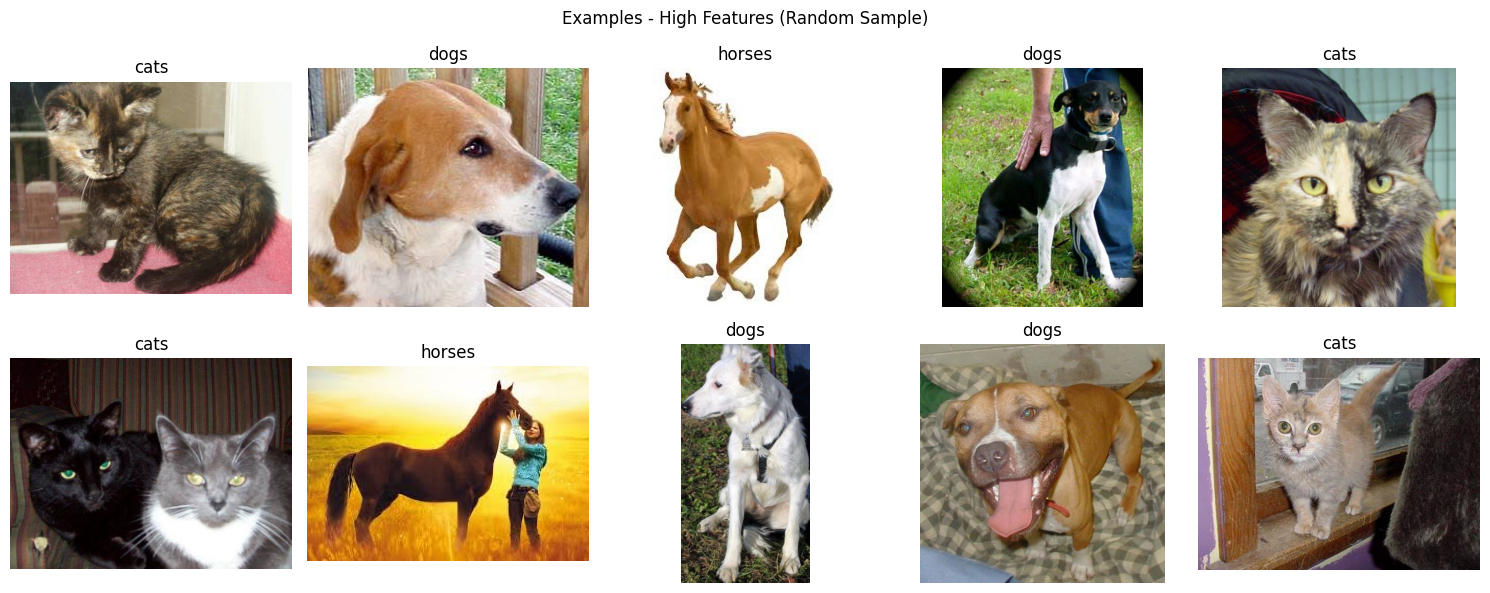


=== BEST CLASSIFIER PER FEATURE TYPE ===
               classifier test_accuracy test_recall_macro test_f1_macro
early   Gradient Boosting      0.647541          0.647561      0.631889
middle       SVM (Linear)      0.836066          0.835976      0.834761
high         SVM (Linear)      0.991803           0.99187       0.99177


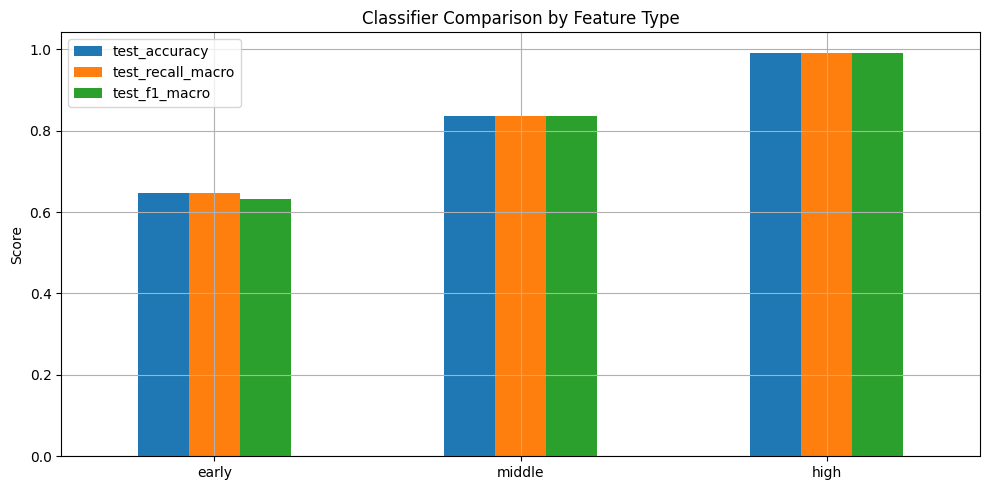

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             f1_score, precision_score, recall_score, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import gc
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def load_dataset_from_folders(dataset_path, image_size=(224, 224)):
    class_names = sorted(os.listdir(dataset_path))
    class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
    images, labels, paths = [], [], []

    for cls in class_names:
        cls_folder = os.path.join(dataset_path, cls)
        if not os.path.isdir(cls_folder): continue
        for img_file in os.listdir(cls_folder):
            if img_file.lower().endswith(('jpg', 'jpeg', 'png')):
                try:
                    img_path = os.path.join(cls_folder, img_file)
                    img = load_img(img_path)
                    img = img.resize(image_size)
                    img_array = preprocess_input(img_to_array(img))
                    images.append(img_array)
                    labels.append(class_to_idx[cls])
                    paths.append(img_path)
                except Exception as e:
                    print(f"Failed: {img_path} ({e})")
    return np.array(images), np.array(labels), class_names, paths

all_images, labels, class_names, image_paths = load_dataset_from_folders('dataset')
print(f"Loaded {len(all_images)} images.")

# ===================== FEATURE EXTRACTION =====================

class ResNetFeatureExtractor:
    def __init__(self):
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False
        self.feature_models = {
            'early': keras.Model(inputs=base_model.input, outputs=base_model.get_layer('conv1_relu').output),
            'middle': keras.Model(inputs=base_model.input, outputs=base_model.get_layer('conv2_block3_out').output),
            'high': keras.Model(inputs=base_model.input, outputs=base_model.output),
        }

    def extract_features(self, images, layer='high', batch_size=16):
        model = self.feature_models[layer]
        features = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            batch_feat = model.predict(batch, verbose=0)
            features.append(batch_feat)
            gc.collect()
        features = np.concatenate(features, axis=0)
        return features.reshape(features.shape[0], -1)

extractor = ResNetFeatureExtractor()
feature_types = ['early', 'middle', 'high']
extracted_features = {}

for ftype in feature_types:
    print(f"Extracting {ftype} features...")
    feat = extractor.extract_features(all_images, layer=ftype)
    extracted_features[ftype] = feat
    np.save(f"saved_features/{ftype}_features.npy", feat)

# ===================== CLASSIFICATION =====================

classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
    'SVM (Linear)': SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, C=1.0, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced')
}

def evaluate(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro')
    }

best_results = {}

for ftype in feature_types:
    print(f"\n--- {ftype.upper()} FEATURES ---")
    X = extracted_features[ftype]
    X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
        X, labels, image_paths, test_size=0.2, random_state=42, stratify=labels)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)


    results = []
    for name, clf in classifiers.items():
        clf.fit(X_train_pca, y_train)
        
        # Evaluate on training set
        y_train_pred = clf.predict(X_train_pca)
        train_metrics = evaluate(y_train, y_train_pred)
        
        # Evaluate on test set
        y_test_pred = clf.predict(X_test_pca)
        test_metrics = evaluate(y_test, y_test_pred)

        result = {
            'classifier': name,
            'train_accuracy': train_metrics['accuracy'],
            'train_f1_macro': train_metrics['f1_macro'],
            'train_recall_macro': train_metrics['recall_macro'],
            'test_accuracy': test_metrics['accuracy'],
            'test_f1_macro': test_metrics['f1_macro'],
            'test_recall_macro': test_metrics['recall_macro'],
        }

        results.append(result)
        print(f"{name}: Train Acc={train_metrics['accuracy']:.4f}, Test Acc={test_metrics['accuracy']:.4f}, "
            f"Test Recall={test_metrics['recall_macro']:.4f}, Test F1={test_metrics['f1_macro']:.4f}")


    df = pd.DataFrame(results)
    # Save best based on test F1
    df = pd.DataFrame(results)
    df_sorted = df.sort_values(by='test_f1_macro', ascending=False)
    best_results[ftype] = df_sorted.iloc[0]

    # Optional: visualize all classifiers
    df.set_index('classifier')[['train_accuracy', 'test_accuracy']].plot(kind='bar', figsize=(10,5))
    plt.title(f"{ftype.capitalize()} Features - Train vs Test Accuracy")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Show 10 example test images
    print(f"\nShowing 10 test examples for {ftype} features:")
    plt.figure(figsize=(15, 6))
    indices = np.random.choice(len(y_test), size=10, replace=False)
    plt.figure(figsize=(15, 6))
    for count, idx in enumerate(indices):
        img = load_img(paths_test[idx])
        plt.subplot(2, 5, count + 1)
        plt.imshow(img)
        plt.title(f"{class_names[y_test[idx]]}")
        plt.axis('off')
    plt.suptitle(f"Examples - {ftype.capitalize()} Features (Random Sample)")
    plt.tight_layout()
    plt.show()

# ===================== COMPARISON =====================

final_df = pd.DataFrame(best_results).T
print("\n=== BEST CLASSIFIER PER FEATURE TYPE ===")
print(final_df[['classifier', 'test_accuracy', 'test_recall_macro','test_f1_macro']])

final_df[['test_accuracy', 'test_recall_macro','test_f1_macro']].plot(kind='bar', figsize=(10, 5))
plt.title("Classifier Comparison by Feature Type")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()